# WeatherPy - *FINAL*

In [205]:
import matplotlib.pyplot as plt
import requests
import pandas as pd
import numpy as np
import json
import scipy.stats as st
from datetime import date
import time
from config import weather_api_key
from config import g_key
from citipy import citipy
import csv

In [206]:
url = url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Build partial query URL
query_url = f'{url}appid={weather_api_key}&units={units}&q='

## Generate Cities List

In [207]:
# Testing citipy nearest_city and country_code
city = citipy.nearest_city(-55.67, 120.2)
city.city_name
city.country_code

'au'

In [220]:
# Create random coordinates dataframe (create enough to account for duplicates and missing weather info)
rand_lat = np.random.uniform(-90,90,1500)
rand_lng = np.random.uniform(-180,180,1500)
lat_lng = pd.DataFrame({'Latitude':rand_lat, 'Longitude':rand_lng})
lat_lng
# rand_lat

,Latitude,Longitude
0,39.052264,-67.944953
1,37.993155,-133.883534
2,-57.428097,-126.005331
3,27.231012,135.700701
4,-22.082196,105.812527
...,...,...
1495,-58.946813,-120.031837
1496,44.282670,-28.616026
1497,48.775476,95.538874
1498,-64.441268,96.017677


In [221]:
cities = []
countries = []

for i in range (0,len(lat_lng['Latitude'])):
    city = citipy.nearest_city(lat_lng['Latitude'][i], lat_lng['Longitude'][i])
    cities.append(city.city_name)
    countries.append(city.country_code)
    
lat_lng['City'] = cities
lat_lng['Country'] = countries

# Count number of cities
len(lat_lng)

1500

In [222]:
lat_lng

,Latitude,Longitude,City,Country
0,39.052264,-67.944953,nantucket,us
1,37.993155,-133.883534,fortuna,us
2,-57.428097,-126.005331,rikitea,pf
3,27.231012,135.700701,kushima,jp
4,-22.082196,105.812527,carnarvon,au
...,...,...,...,...
1495,-58.946813,-120.031837,rikitea,pf
1496,44.282670,-28.616026,lagoa,pt
1497,48.775476,95.538874,erzin,ru
1498,-64.441268,96.017677,busselton,au


In [223]:
# Check for duplicated cities
# lat_lng['City'].duplicated().value_counts()

lat_lng['City'].value_counts()

# Alternatively, use: lat_lng['City'].nunique()

rikitea         54
ushuaia         48
albany          39
mataura         35
punta arenas    29
                ..
dalvik           1
nabire           1
mundargi         1
krasnoselkup     1
senanga          1
Name: City, Length: 587, dtype: int64

In [224]:
# Drop duplicate cities, but keep first instance 
lat_lng.drop_duplicates(subset='City', keep='first', inplace=True)

In [225]:
# Check if duplicates have dropped off
lat_lng['City'].value_counts()

portland         1
cape town        1
saint anthony    1
road town        1
tessalit         1
                ..
tungkang         1
drezdenko        1
coos bay         1
avarua           1
senanga          1
Name: City, Length: 587, dtype: int64

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [226]:
requests.get('http://api.openweathermap.org/data/2.5/weather?q=london&appid=47e33a210410942f6c73a407a06be6e5')

<Response [200]>

In [227]:
# 1-City Get Test
requests.get(query_url+'london').json()

{'coord': {'lon': -0.1257, 'lat': 51.5085},
 'weather': [{'id': 804,
   'main': 'Clouds',
   'description': 'overcast clouds',
   'icon': '04n'}],
 'base': 'stations',
 'main': {'temp': 59.2,
  'feels_like': 59.14,
  'temp_min': 56.98,
  'temp_max': 60.69,
  'pressure': 1015,
  'humidity': 92},
 'visibility': 10000,
 'wind': {'speed': 9.22, 'deg': 230},
 'clouds': {'all': 99},
 'dt': 1628547129,
 'sys': {'type': 2,
  'id': 2019646,
  'country': 'GB',
  'sunrise': 1628483804,
  'sunset': 1628537722},
 'timezone': 3600,
 'id': 2643743,
 'name': 'London',
 'cod': 200}

In [228]:
# Create city data list to append to
city_data = []

# Print initial request
print('Beginning Data Retrieval')
print('-----------------------------')

# Create record counter
record_count = 1

# Loop through each city in lat_lng list
# if limited, stall code at each iteration (with time.sleep)
for x in lat_lng['City'][:]:
    try:
        response = requests.get(query_url+x).json()
        
        city = response['name']
        lon = response['coord']['lon']
        lat = response['coord']['lat']
        temp_max = response['main']['temp_max']
        humidity = response['main']['humidity']
        cloudiness = response['clouds']['all']
        wind_speed = response['wind']['speed']
        country = response['sys']['country']
        date = response['dt']
        
        city_data.append({'City':city,
                          'Longitude':lon,
                          'Latitude':lat,
                          'Max Temperature':temp_max,
                          'Humidity':humidity,
                          'Cloudiness':cloudiness,
                          'Wind Speed':wind_speed,
                          'Country':country,
                          'Date':date})
        
        # Indicate city has been loaded
        print("Processed Record %s | %s" % (record_count, city))
        
        # Add 1 to record count
        record_count = record_count + 1
        
    # If error occurs, skip city
    except:
        print("City not found. Skipping...")
        pass

# Indicate all data has been loaded
print('-----------------------------')
print('Data Retrieval Complete')
print('-----------------------------')

Beginning Data Retrieval
-----------------------------
Processed Record 1 | Nantucket
Processed Record 2 | Fortuna
Processed Record 3 | Rikitea
Processed Record 4 | Kushima
Processed Record 5 | Carnarvon
Processed Record 6 | Hobart
City not found. Skipping...
Processed Record 7 | Avarua
Processed Record 8 | Albany
Processed Record 9 | Punta Arenas
Processed Record 10 | Shingū
Processed Record 11 | Kaitangata
City not found. Skipping...
Processed Record 12 | Constitución
Processed Record 13 | Idrinskoye
Processed Record 14 | Williamsburg
Processed Record 15 | Iqaluit
Processed Record 16 | Tuatapere
Processed Record 17 | Ixtapa
Processed Record 18 | Vardø
Processed Record 19 | Katsuura
Processed Record 20 | Ahipara
Processed Record 21 | Roebourne
Processed Record 22 | Torbay
Processed Record 23 | Ushuaia
Processed Record 24 | Ciudad Real
Processed Record 25 | Inírida
Processed Record 26 | Tuy Hoa
Processed Record 27 | Puerto Ayora
Processed Record 28 | Isangel
Processed Record 29 | Shiro

Processed Record 232 | Bajil
Processed Record 233 | Yeppoon
Processed Record 234 | Tiznit Province
Processed Record 235 | Pedernales
Processed Record 236 | Kruisfontein
Processed Record 237 | Uusikaupunki
Processed Record 238 | Klaksvík
Processed Record 239 | Vao
Processed Record 240 | Deputatsky
Processed Record 241 | Mount Isa
Processed Record 242 | Gangtok
City not found. Skipping...
Processed Record 243 | Wanning
Processed Record 244 | Hamilton
Processed Record 245 | Zhongshu
Processed Record 246 | Chumikan
Processed Record 247 | Manadhoo
Processed Record 248 | Nabire
Processed Record 249 | Salalah
Processed Record 250 | Hithadhoo
Processed Record 251 | Wilmington
Processed Record 252 | Solnechnyy
Processed Record 253 | Cabedelo
Processed Record 254 | Atar
City not found. Skipping...
Processed Record 255 | Zhigansk
Processed Record 256 | Vanavara
Processed Record 257 | Mendi
City not found. Skipping...
Processed Record 258 | Puerto Madero
Processed Record 259 | Pitimbu
Processed Re

Processed Record 469 | Carutapera
Processed Record 470 | Aripuanã
Processed Record 471 | Talcahuano
Processed Record 472 | Elizabeth City
City not found. Skipping...
Processed Record 473 | Masterton
Processed Record 474 | Juan Lacaze
Processed Record 475 | Kirakira
Processed Record 476 | Wangaratta
Processed Record 477 | Pizhanka
Processed Record 478 | Hirara
Processed Record 479 | Kayes
Processed Record 480 | Basirpur
Processed Record 481 | Birao
Processed Record 482 | Jardim
Processed Record 483 | Fort Frances
Processed Record 484 | Zhangjiakou
Processed Record 485 | San Patricio
Processed Record 486 | Nerchinskiy Zavod
Processed Record 487 | Camaçari
Processed Record 488 | Freeport
Processed Record 489 | Safakulevo
Processed Record 490 | Makīnsk
Processed Record 491 | Teya
Processed Record 492 | Camopi
Processed Record 493 | Mindelo
Processed Record 494 | Mogadishu
Processed Record 495 | Karwar
Processed Record 496 | Gorontalo
Processed Record 497 | Bud
Processed Record 498 | Kenai


In [229]:
# Test the output of above
city_data

[{'City': 'Nantucket',
  'Longitude': -70.0995,
  'Latitude': 41.2835,
  'Max Temperature': 73.96,
  'Humidity': 90,
  'Cloudiness': 90,
  'Wind Speed': 10.36,
  'Country': 'US',
  'Date': 1628547712},
 {'City': 'Fortuna',
  'Longitude': -124.1573,
  'Latitude': 40.5982,
  'Max Temperature': 71.85,
  'Humidity': 72,
  'Cloudiness': 1,
  'Wind Speed': 16.11,
  'Country': 'US',
  'Date': 1628547712},
 {'City': 'Rikitea',
  'Longitude': -134.9692,
  'Latitude': -23.1203,
  'Max Temperature': 72.64,
  'Humidity': 83,
  'Cloudiness': 55,
  'Wind Speed': 8.81,
  'Country': 'PF',
  'Date': 1628547712},
 {'City': 'Kushima',
  'Longitude': 131.2333,
  'Latitude': 31.4583,
  'Max Temperature': 80.64,
  'Humidity': 89,
  'Cloudiness': 43,
  'Wind Speed': 4.7,
  'Country': 'JP',
  'Date': 1628547713},
 {'City': 'Carnarvon',
  'Longitude': 113.6333,
  'Latitude': -24.8667,
  'Max Temperature': 64.47,
  'Humidity': 63,
  'Cloudiness': 90,
  'Wind Speed': 13.8,
  'Country': 'AU',
  'Date': 1628547713

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [230]:
# Export the city data into a .csv.

# Set keys
keys = city_data[0].keys()

# Use csv.DictWriter to write CSV
city_data_csv = open("../output_data/city_data.csv", "w")
dict_writer = csv.DictWriter(city_data_csv, keys)
dict_writer.writeheader()
dict_writer.writerows(city_data)
city_data_csv.close()

In [231]:
# Display the DataFrame
city_data_df = pd.DataFrame(city_data)
city_data_df

,City,Longitude,Latitude,Max Temperature,Humidity,Cloudiness,Wind Speed,Country,Date
0,Nantucket,-70.0995,41.2835,73.96,90,90,10.36,US,1628547712
1,Fortuna,-124.1573,40.5982,71.85,72,1,16.11,US,1628547712
2,Rikitea,-134.9692,-23.1203,72.64,83,55,8.81,PF,1628547712
3,Kushima,131.2333,31.4583,80.64,89,43,4.70,JP,1628547713
4,Carnarvon,113.6333,-24.8667,64.47,63,90,13.80,AU,1628547713
...,...,...,...,...,...,...,...,...,...
533,Florianópolis,-48.5012,-27.6146,65.25,88,0,12.66,BR,1628547952
534,Gweta,25.2333,-20.1833,67.50,17,2,2.68,BW,1628547952
535,Lagoa,-27.9833,39.0500,71.42,83,4,7.54,PT,1628547953
536,Erzin,36.2000,36.9559,81.32,79,0,0.85,TR,1628547953


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [232]:
city_data_df.describe()

,Longitude,Latitude,Max Temperature,Humidity,Cloudiness,Wind Speed,Date
count,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,5.380000e+02
mean,20.582350,21.092914,69.197249,72.260223,51.349442,7.618253,1.628548e+09
std,90.776353,33.222716,14.077945,20.467332,39.010439,5.899461,8.797625e+01
min,-175.200000,-54.800000,35.530000,10.000000,0.000000,0.000000,1.628547e+09
25%,-60.424175,-6.008100,57.620000,62.000000,10.250000,3.425000,1.628548e+09
50%,23.825000,26.355800,71.375000,77.500000,49.000000,6.220000,1.628548e+09
75%,99.920825,49.229100,80.000000,88.000000,90.000000,10.472500,1.628548e+09
max,179.316700,78.218600,104.470000,100.000000,100.000000,36.820000,1.628548e+09


In [233]:
#  Get the indices of cities that have humidity over 100%.


In [234]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

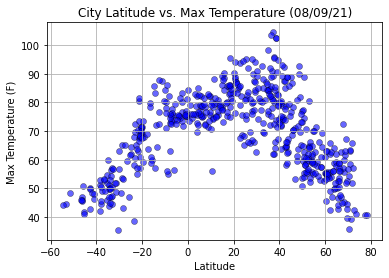

In [235]:
# Personalize scatterplot
plt.scatter(city_data_df['Latitude'], 
            city_data_df['Max Temperature'], 
            color = "blue", 
            marker = "o", 
            alpha = 0.6, 
            linewidths = .5, 
            edgecolors = "black")

# Create labels
plt.title("City Latitude vs. Max Temperature (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.grid(True)

# Save the figure
plt.savefig("../output_data/Latitude vs Temperature.png")

# Show plot
plt.show()

**CODE**: The code above uses matplotlib to plot the relationship between City Latitude and Max Temperature for each city, as requested from the OpenWeather API. Each dot on the scatterplot represents one city, and the darker areas represent where one or more overlapping dots.

**ANALYSIS**: The scatterplot supported our prior knowledge that cities closer to the poles tend to have a lower temperatures and cities closer to the equator tend to have a higher temperatures. We expected the highest temperatures to be between -20 and 0, or 0 and +20 latitudes, but they ended up being between +20 and +40. It should be noted that there is also greater temperature range at these latitudes, whereas the range of temperatures was less at the -20 to 0, and 0 to +20 latitudes.

## Latitude vs. Humidity Plot

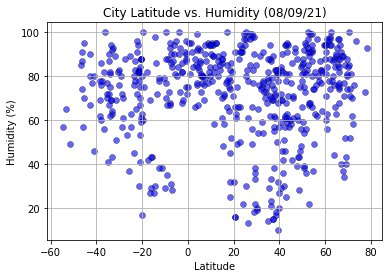

In [236]:
# Personalize scatterplot
plt.scatter(city_data_df['Latitude'], 
            city_data_df['Humidity'], 
            color = "blue", 
            marker = "o", 
            alpha = 0.6, 
            linewidths = .5, 
            edgecolors = "black")

# Create labels
plt.title("City Latitude vs. Humidity (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.grid(True)

# Save the figure
plt.savefig("../output_data/Latitude vs Humidity.png")

# Show plot
plt.show()

**CODE**: The code above uses matplotlib to plot the relationship between City Latitude and Humidity Percentage for each city, as requested from the OpenWeather API. Each dot on the scatterplot represents one city, and the darker areas represent where one or more overlapping dots.

**ANALYSIS**: The scatterplot does not seem to show any significant relationship of City Latitude and Humidity. However, it should be noted that the latitude ranges of about -40 to 0 and +20 to +60 have the lowest Humidity levels, with a blank space formed between the two ranges. The hottest temperatures might be at the equator, but the most consistently humid areas are also there.

## Latitude vs. Cloudiness Plot

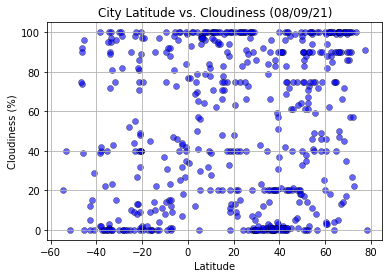

In [237]:
# Personalize scatterplot
plt.scatter(city_data_df['Latitude'], 
            city_data_df['Cloudiness'], 
            color = "blue", 
            marker = "o", 
            alpha = 0.6, 
            linewidths = .5, 
            edgecolors = "black")

# Create labels
plt.title("City Latitude vs. Cloudiness (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.grid(True)

# Save the figure
plt.savefig("../output_data/Latitude vs Cloudiness.png")

# Show plot
plt.show()

**CODE**: The code above uses matplotlib to plot the relationship between Latitude and Cloudiness for each city, as requested from the OpenWeather API. Each dot on the scatterplot represents one city, and the darker areas represent where one or more overlapping dots.

**ANALYSIS**: The scatterplot does not show any sort of relationship between City Latitude and Cloudiness. Further research could be done into why there are dark spots of 100% Cloudiness and 0% Cloudiness at a few Latitudes.

## Latitude vs. Wind Speed Plot

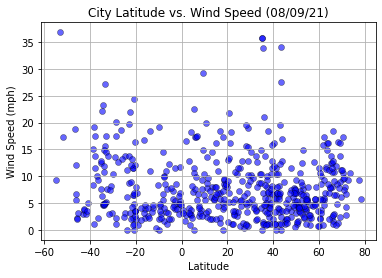

In [238]:
# Personalize scatterplot
plt.scatter(city_data_df['Latitude'], 
            city_data_df['Wind Speed'], 
            color = "blue", 
            marker = "o", 
            alpha = 0.6, 
            linewidths = .5, 
            edgecolors = "black")

# Create labels
plt.title("City Latitude vs. Wind Speed (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.grid(True)

# Save the figure
plt.savefig("../output_data/Latitude vs Wind Speed.png")

# Show plot
plt.show()

**CODE**: The code above uses matplotlib to plot the relationship between City Latitude and Wind Speed (mph) for each city, as requested from the OpenWeather API. Each dot on the scatterplot represents one city, and the darker areas represent where one or more overlapping dots.

**ANALYSIS**: The scatterplot does not show significant relationship between City Latitude and Wind Speed (mph). Further research could be done to look into weather patterns at the location of the outliers.

## Linear Regression

In [239]:
# Break city_data_df into Northern and Southern Hemispheres
n_hemi = city_data_df.loc[city_data_df["Latitude"] >=0]
s_hemi = city_data_df.loc[city_data_df["Latitude"] <0]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r value is -0.6674492560173119


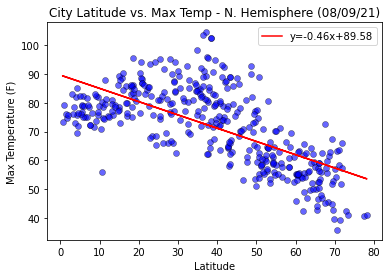

In [240]:
# Use scipy linregress to get regression statistics
x = n_hemi["Latitude"]
y = n_hemi["Max Temperature"]

# Set linear regression values
slope, intercept, r_value, p_value, std_err = st.linregress(x, y)

# Setup Graph
plt.title("City Latitude vs. Max Temp - N. Hemisphere (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")

plt.scatter(x, y, 
            color = "blue", 
            marker = "o", 
            alpha = 0.6, 
            linewidths = .5, 
            edgecolors = "black")

# Create line and plot with equation
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))

plt.legend(fontsize=10)

# Save figure
plt.savefig("../output_data/N. Hemisphere - Latitude vs Max Temp - Linear Regression.png")

# Print r-value
print(f'The r value is {r_value}')

**SUMMARY**: The linear regression line above (in red) shows the relationship between City Latitude and Max Temperature (F) for the Northern Hemisphere. The Pearson Correlation Coefficient (r value) is -0.667, indicating *some* negative correlation between the two factors; as latitude increases from 0 to +80, temperature generally decreases. However, if we were to break this scatterplot up at the +20 degree latitude, we might see a *positive* correlation from 0 to +20 and a *negative* correlation from +20 to +80.

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r value is 0.8334102215822348


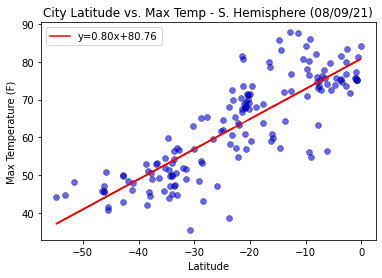

In [241]:
# Use scipy linregress to get regression statistics
x = s_hemi["Latitude"]
y = s_hemi["Max Temperature"]

# Set linear regression values
slope, intercept, r_value, p_value, std_err = st.linregress(x, y)

# Setup Graph
plt.title("City Latitude vs. Max Temp - S. Hemisphere (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")

plt.scatter(x, y, 
            color = "blue", 
            marker = "o", 
            alpha = 0.6, 
            linewidths = .5, 
            edgecolors = "black")

# Create line and plot with equation
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))

plt.legend(fontsize=10)

# Save figure
plt.savefig("../output_data/S. Hemisphere - Latitude vs Max Temp - Linear Regression.png")

# Print r-value
print(f'The r value is {r_value}')

**SUMMARY**: The linear regression line above (in red) shows the relationship between City Latitude and Max Temperature (F) for the Southern Hemisphere. The Pearson Correlation Coefficient (r value) is -0.833, indicating *strong* postitive correlation between the two factors; as latitude increases from 0 to +80, temperature generally increases.

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r value is -0.023401911621776503


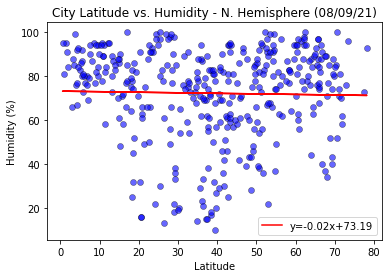

In [242]:
# Use scipy linregress to get regression statistics
x = n_hemi["Latitude"]
y = n_hemi["Humidity"]

# Set linear regression values
slope, intercept, r_value, p_value, std_err = st.linregress(x, y)

# Setup Graph
plt.title("City Latitude vs. Humidity - N. Hemisphere (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

plt.scatter(x, y, 
            color = "blue", 
            marker = "o", 
            alpha = 0.6, 
            linewidths = .5, 
            edgecolors = "black")

# Create line and plot with equation
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))

plt.legend(fontsize=10)

# Save figure
plt.savefig("../output_data/N. Hemisphere - Latitude vs Humidity - Linear Regression.png")

# Print r-value
print(f'The r value is {r_value}')

**SUMMARY**: The linear regression line above (in red) shows the relationship between City Latitude and Max Temperature (F) for the Northern Hemisphere. The Pearson Correlation Coefficient (r value) is -0.667, which means there is *some* negative correlation between the two factors; as latitude increases from 0 to +80, temperature generally decreases. However, if we were to break this scatterplot up at the +20 degree latitude, we might see a *positive* correlation from 0 to +20 and a *negative* correlation from +20 to +80.

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r value is 0.06962249700546233


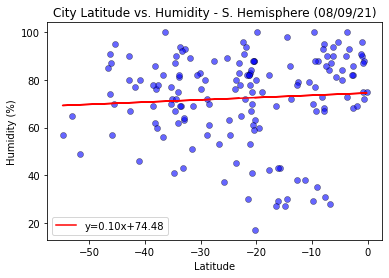

In [243]:
# Use scipy linregress to get regression statistics
x = s_hemi["Latitude"]
y = s_hemi["Humidity"]

# Set linear regression values
slope, intercept, r_value, p_value, std_err = st.linregress(x, y)

# Setup Graph
plt.title("City Latitude vs. Humidity - S. Hemisphere (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

plt.scatter(x, y, 
            color = "blue", 
            marker = "o", 
            alpha = 0.6, 
            linewidths = .5, 
            edgecolors = "black")

# Create line and plot with equation
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))

plt.legend(fontsize=10)

# Save figure
plt.savefig("../output_data/S. Hemisphere - Latitude vs Humidity - Linear Regression.png")

# Print r-value
print(f'The r value is {r_value}')

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r value is 0.019573295263963668


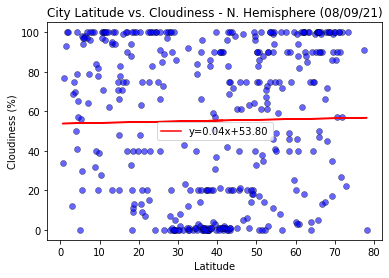

In [244]:
# Use scipy linregress to get regression statistics
x = n_hemi["Latitude"]
y = n_hemi["Cloudiness"]

# Set linear regression values
slope, intercept, r_value, p_value, std_err = st.linregress(x, y)

# Setup Graph
plt.title("City Latitude vs. Cloudiness - N. Hemisphere (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

plt.scatter(x, y, 
            color = "blue", 
            marker = "o", 
            alpha = 0.6, 
            linewidths = .5, 
            edgecolors = "black")

# Create line and plot with equation
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))

plt.legend(fontsize=10)

# Save figure
plt.savefig("../output_data/N. Hemisphere - Latitude vs Cloudiness - Linear Regression.png")

# Print r-value
print(f'The r value is {r_value}')

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r value is 0.0919578028174029


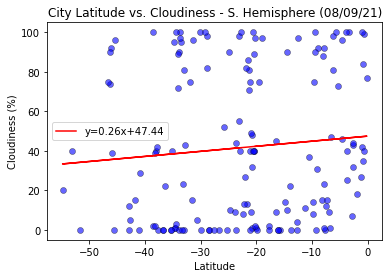

In [245]:
# Use scipy linregress to get regression statistics
x = s_hemi["Latitude"]
y = s_hemi["Cloudiness"]

# Set linear regression values
slope, intercept, r_value, p_value, std_err = st.linregress(x, y)

# Setup Graph
plt.title("City Latitude vs. Cloudiness - S. Hemisphere (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

plt.scatter(x, y, 
            color = "blue", 
            marker = "o", 
            alpha = 0.6, 
            linewidths = .5, 
            edgecolors = "black")

# Create line and plot with equation
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))

plt.legend(fontsize=10)

# Save figure
plt.savefig("../output_data/S. Hemisphere - Latitude vs Cloudiness - Linear Regression.png")

# Print r-value
print(f'The r value is {r_value}')

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r value is -0.0337284843332768


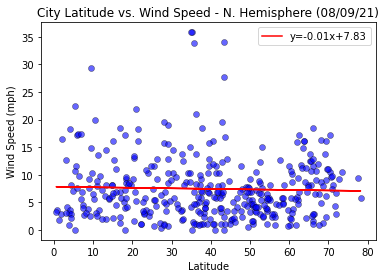

In [246]:
# Use scipy linregress to get regression statistics
x = n_hemi["Latitude"]
y = n_hemi["Wind Speed"]

# Set linear regression values
slope, intercept, r_value, p_value, std_err = st.linregress(x, y)

# Setup Graph
plt.title("City Latitude vs. Wind Speed - N. Hemisphere (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")

plt.scatter(x, y, 
            color = "blue", 
            marker = "o", 
            alpha = 0.6, 
            linewidths = .5, 
            edgecolors = "black")

# Create line and plot with equation
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))

plt.legend(fontsize=10)

# Save figure
plt.savefig("../output_data/N. Hemisphere - Latitude vs Wind Speed - Linear Regression.png")

# Print r-value
print(f'The r value is {r_value}')

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r value is -0.2879491253123776


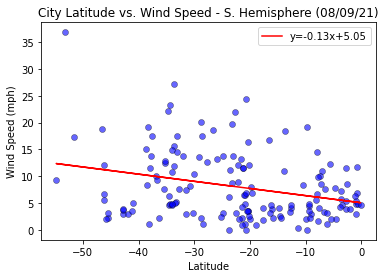

In [247]:
# Use scipy linregress to get regression statistics
x = s_hemi["Latitude"]
y = s_hemi["Wind Speed"]

# Set linear regression values
slope, intercept, r_value, p_value, std_err = st.linregress(x, y)

# Setup Graph
plt.title("City Latitude vs. Wind Speed - S. Hemisphere (%s)" % time.strftime("%x"))
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")

plt.scatter(x, y, 
            color = "blue", 
            marker = "o", 
            alpha = 0.6, 
            linewidths = .5, 
            edgecolors = "black")

# Create line and plot with equation
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))

plt.legend(fontsize=10)

# Save figure
plt.savefig("../output_data/S. Hemisphere - Latitude vs Wind Speed - Linear Regression.png")

# Print r-value
print(f'The r value is {r_value}')